In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
sns.set_context(context="talk")
%matplotlib inline

from keras import backend as K
import keras
import os, re, sys
import pandas as pd
from keras.utils import to_categorical
import ast
from sklearn.utils import class_weight
from keras.preprocessing import sequence
from keras.models import load_model
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time
from keras.models import load_model
from keras import backend as K
import keras
'''
Compatible with tensorflow backend
gamma entre más alto más tolerante (queremos un gamma chico pero no demasiado! 0.25 - 5)
alpha pesos por clase (weights)
'''
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE


Using TensorFlow backend.


In [2]:
#'baselines_4/cnn1_ce10_100.h5'
print ("Nh\t\t| IH\t\t| PH\t\t| SH\t\t| F-Macro")
print (0.92792793 ,'\t',0. ,'\t\t',        0.,'\t\t',         0.84057971,'\t',    0.4421269095182139)
#('baselines_4/cnn1_focal10_100.h5')
print (0.78674791,'\t', 0.13793103 ,'\t',0.09756098 ,'\t',0.56389987,'\t',   0.396534945974999  )
#('baselines_4/rnn_simple_100_focal15.h5')
print (0.9197861  ,'\t',0.10884354 ,'\t',0.0729927  ,'\t',0.78439425,'\t',  0.47150414622873116)
#('baselines_4/rnn1_100_focal15.h5')
print (0.92418033,'\t', 0.14876033 ,'\t',0.17073171 ,'\t',0.85254692,'\t',  0.5240548206636296)
#('baselines_4/rnn2_100_focal15.h5')
print (0.9054658 ,'\t', 0.13714286 ,'\t',0.10909091 ,'\t',0.74418605,'\t',  0.47397140213787825)
#('baselines_4/rnn3_100_focal15.h5')
print (0.78454333 ,'\t',0.10327022,'\t', 0.10362694 ,'\t',0.71553611,'\t', 0.42674414932927196)
#('baselines_4/cnn1_focal10_100_g3_100.h5')
print (0.91473851 ,'\t',0. ,'\t\t',        0.09386282 ,'\t',0.52150538,'\t',    0.38252667563241805)

#pasan a transformer: 1,2,7,8,9,10,12

Nh		| IH		| PH		| SH		| F-Macro
0.92792793 	 0.0 		 0.0 		 0.84057971 	 0.4421269095182139
0.78674791 	 0.13793103 	 0.09756098 	 0.56389987 	 0.396534945974999
0.9197861 	 0.10884354 	 0.0729927 	 0.78439425 	 0.47150414622873116
0.92418033 	 0.14876033 	 0.17073171 	 0.85254692 	 0.5240548206636296
0.9054658 	 0.13714286 	 0.10909091 	 0.74418605 	 0.47397140213787825
0.78454333 	 0.10327022 	 0.10362694 	 0.71553611 	 0.42674414932927196
0.91473851 	 0.0 		 0.09386282 	 0.52150538 	 0.38252667563241805


In [3]:
cnn_100_c = load_model('baselines_4/cnn1_ce10_100.h5')
#cnn_100_f = load_model('baselines_4/cnn1_focal10_100.h5')
gru_s = load_model('baselines_4/rnn_simple_100_focal15.h5')
gru1 = load_model('baselines_4/rnn1_100_focal15.h5')
gru2 = load_model('baselines_4/rnn2_100_focal15.h5')
#gru3 = load_model('baselines_4/rnn3_100_focal15.h5')
#cnn_100_f3 = load_model('baselines_4/cnn1_focal10_100_g3_100.h5')


list_models=['cnn_100_c', 'gru_s', 'gru1', 'gru2']
index_models=np.arange(4)
dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
modelos=[cnn_100_c, gru_s, gru1, gru2]
ind=np.arange(4)
dict_trainingModel=dict((key, value) for (key, value) in zip(ind,modelos))

In [4]:
predicciones_all=[]
X_train=np.load("matrices/X_train_4.npy")
X_train_rnn=np.load("../../../respSIMAH/X_train_rnn_4.npy")

bs=32
for i in dict_trainingModel.keys(): 
    print ("Agregando predicciones del modelo", dict_models[i])
    a_evaluar=dict_models[i]
    if a_evaluar[:3]!='gru':
        predicciones_all.append(dict_trainingModel[i].predict(X_train, batch_size=bs))
    else:
        predicciones_all.append(dict_trainingModel[i].predict(X_train_rnn, batch_size=bs))
        
predicciones_all_val=[]
X_val=np.load("matrices/X_val_ig_4.npy")
X_val_rnn=np.load("matrices/X_val_rnn_ig_4.npy")

bs=32
for i in dict_trainingModel.keys(): 
    print ("Agregando predicciones val del modelo", dict_models[i])
    a_evaluar=dict_models[i]
    if a_evaluar[:3]!='gru':
        predicciones_all_val.append(dict_trainingModel[i].predict(X_val, batch_size=bs))
    else:
        predicciones_all_val.append(dict_trainingModel[i].predict(X_val_rnn, batch_size=bs))
        

Agregando predicciones del modelo cnn_100_c
Agregando predicciones del modelo gru_s
Agregando predicciones del modelo gru1
Agregando predicciones del modelo gru2
Agregando predicciones val del modelo cnn_100_c
Agregando predicciones val del modelo gru_s
Agregando predicciones val del modelo gru1
Agregando predicciones val del modelo gru2


In [5]:
predicciones_all_test=[]
X_test=np.load("matrices/X_test_ig_4.npy")
X_test_rnn=np.load("matrices/X_test_rnn_4.npy")

bs=32
for i in dict_trainingModel.keys(): 
    print ("Agregando predicciones test del modelo", dict_models[i])
    a_evaluar=dict_models[i]
    if a_evaluar[:3]!='gru':
        predicciones_all_test.append(dict_trainingModel[i].predict(X_test, batch_size=bs))
    else:
        predicciones_all_test.append(dict_trainingModel[i].predict(X_test_rnn, batch_size=bs))

Agregando predicciones test del modelo cnn_100_c
Agregando predicciones test del modelo gru_s
Agregando predicciones test del modelo gru1
Agregando predicciones test del modelo gru2


In [6]:
matrix=np.asarray(predicciones_all)
print (matrix.shape)
matrix_val=np.asarray(predicciones_all_val)
print (matrix_val.shape)
matrix_test=np.asarray(predicciones_all_test)
print (matrix_test.shape)

(4, 6374, 4)
(4, 2125, 4)
(4, 2123, 4)


In [7]:
new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)
new_matrix.shape

(4, 10622, 4)

In [8]:
class Dummy_Embeddings(nn.Module):
    def __init__(self, d_model, dummy_vectors): 
        super(Dummy_Embeddings, self).__init__()
        aux = torch.from_numpy(dummy_vectors)#, dtype='float32'))
        self.index2dummy = nn.Embedding(aux.size()[0], d_model)
        self.index2dummy.weigth=nn.Parameter(aux)
        self.index2dummy.weigth.requires_grad=False
        self.d_model = d_model
        
    def forward(self, x):
        aux=x.numpy()
        #print ("aux_size en dummy emb", aux.shape, aux)
        new_x= aux - np.ones(aux.shape)#cambiar aqui! (ver hojita de cuaderno)
        new_x= torch.from_numpy(new_x)
        #print ("nuevo aux con el menos 1s (clase 1 en ind 0 y los ids desde 5 ind)", aux)
        return self.index2dummy(new_x.long()) * math.sqrt(self.d_model) #debiese retornar matriz de batch_size x [ind_tw, k1,k2,k3,k4,k5,k6] (si son 6 modelos)
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
class EncoderDecoderLogSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderLogSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        out=self.encode(src, src_mask)
        retorno=self.toSoftmax(out)
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.log_softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class EncoderDecoderSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        out=self.encode(src, src_mask)
        retorno=self.toSoftmax(out)
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
            
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, src_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        self.generator = generator
        
    def forward(self, src, src_mask):
        return  self.encode(src, src_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))    
    
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)
    
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
    
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
         
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
    
class PositionalText(nn.Module):
    def __init__(self, d_model, dropout, max_len=5):
        super(PositionalText, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x_text=x.data[:,0][:,None,:]
        x_machines=x.data[:,1:]
        
        x_return = x_machines* x_text
        return self.dropout(x_return)
    
class PositionalText_concat(nn.Module):
    def __init__(self, d_model, dropout, max_len=5):
        super(PositionalText_concat, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        return self.dropout(x)

In [9]:
def data_gen(batch_size,mode,n_machines,new_matrix):  
    """ESTA FUNCION DEBERÁ RETORNAR MATRICES DE TAMAÑO BATCH_SIZE * TW,M1,M2,M3,M4,M5,M6
    CADA EJEMPLO DEBERÁ SER ESTILO [ID_T, 1,2,1,2,1,2] SIENDO 1 CUANDO LA CLASE PREDICHA ES LA 0
    2 PARA CLASE PREDICHA 1, ETC. ID_T DEBEŔA INICIAR EN 5 PARA REFERIRSE AL PRIMER TW (EL PRIMERO DE TRAIN)"""
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=matrix.shape[1]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)
        objs=df_train['Unnamed: 0'].values
        objs=[obj+5 for obj in objs]
        labels=np.load("matrices/y_train_num_4.npy")
        labels=labels+ np.ones(labels.shape)       
    if mode=='Val':
        max_objs=matrix_val.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1] for x in x_list]
        np.random.shuffle(x_list)
        objs=df_val['Unnamed: 0'].values        
        objs=[obj+5 for obj in objs]
        labels=np.load("matrices/y_val_num_4.npy")
        labels=labels+ np.ones(labels.shape) 
    if mode=='Test':
        max_objs=matrix_test.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1]+matrix_val.shape[1] for x in x_list]
        #np.random.shuffle(x_list)
        #print ("X LIST SIN SHUFFLE", x_list)
        total=matrix.shape[1]+matrix_val.shape[1]
        objs=np.arange(total, total+max_objs)
        objs=[obj+5 for obj in objs]
        
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
    
    new_x_data=[] 
    for batch in x_data:
        temp=[]
        for exam in batch:
            if mode=='Train':
                temp2=[objs[exam]] ### obj evaluado en maquinas
            elif mode=='Val':
                temp2=[objs[exam-matrix.shape[1]]] 
            else:
                temp2=[objs[exam-matrix.shape[1]-matrix_val.shape[1]]]                
            for m in range(n_machines): 
                temp2= temp2 + [np.argmax(new_matrix[m][exam])+1] 
            temp.append(temp2)
        new_x_data.append(temp)   

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for batch in new_x_data:
            temp_y=[]
            for exam in batch:
                q=exam[0]
                indice=match(objs, q)    
                temp_y.append([labels[indice]])       
            y_data.append(temp_y)
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)
    
    if mode=='Train' or mode=='Val':
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)
    else:
        for x in new_x_data:
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)

In [10]:
df_train=pd.read_csv("../Train_data_compeition.csv")
df_val=pd.read_csv("../Validation_data_competition.csv")
df_test=pd.read_csv("../testset-competition.csv")
df_train.head()

,Unnamed: 0,tweet_content,harassment,IndirectH,PhysicalH,SexualH
0,0,pics mexican school girl naked melanie safka f...,1,0,0,1
1,1,RT shereiqns Having curly hair is a gotdamn ch...,0,0,0,0
2,2,BreakingNews 7 Unexplained Prisoners Deaths M...,0,0,0,0
3,3,girl dirty quarterback latino pokemon young h...,1,0,0,1
4,4,miliondollameat sexting n ngirl daddy n nme l...,1,0,0,1


In [11]:
Ks=np.load("../Orthogonals_768.npy")
print (Ks.shape)
random=np.random.randint(Ks.shape[0], size=4)
K_list=[Ks[k] for k in random]
print (np.asarray(K_list).shape)
len(K_list)

(768, 768)
(4, 768)


4

# por qué parte en 5?

In [12]:
K_list_ext=K_list
objs_train=df_train['Unnamed: 0'].values
objs_val=df_val['Unnamed: 0'].values
objs_test=np.arange(df_test.shape[0])
tope=len(objs_train)+len(objs_val)
objs_test=[elem+tope for elem in objs_test]
print (objs_train.shape)
print (objs_val.shape)
print (len(objs_test))
#print (objs_test.shape)
llaves=np.concatenate([objs_train,objs_val,objs_test])
#valores=np.arange(5, len(objs_train)+len(objs_val)+len(objs_test)+5)
len(llaves)

(6374,)
(2125,)
2123


10622

In [13]:
#dict_IDObj=dict((key, value) for (key, value) in zip(llaves,valores))
#dict_ObjID=dict((key, value) for (key, value) in zip(valores,llaves))
#len(dict_ObjID)

In [14]:
contador=0
for i in range(tope):
    vector=np.load("../../vectors/"+str(i)+".npy")
    K_list_ext.append(vector[0])
for i in range(len(objs_test)):
    vector=np.load("../../test_vectors/"+str(i)+".npy")
    K_list_ext.append(vector[0])
print ("largo de lista de vectores bert (considerando dummy clases)", len(K_list_ext))
    

largo de lista de vectores bert (considerando dummy clases) 10626


In [15]:
len(K_list_ext)

10626

In [16]:
K_list_new= np.asarray(K_list_ext, dtype='float32')
K_list_new.shape

(10626, 768)

In [17]:
def make_model_concat(target, N=2, d_model=768, d_ff=1024, h=4, dropout=0.3, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText_concat(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(768, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(768, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :]
            self.trg_y = trg[:, 0:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask
    
def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            total_datos = 0
            total_loss = 0
            total_acc=0
            total_fm1=0
            total_fs=0
            n_batches = 0
            cm_last=np.zeros((4,4))
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
                #la loss del batch es sobre todos los ejemplos o es promedio en batch?
                
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):
            out = model.forward(batch.src, batch.src_mask)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0
            total_fs += f1  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last

In [18]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of learners + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    maximo=max(src_elements, tgt_elements)
    return maximo

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        #print ("Rate de Noam_opt", self._rate, self._step)
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        mask = torch.nonzero(target.data == self.padding_idx)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))
    
class LabelCCE(nn.Module):
    def __init__(self, class_weights):
        super(LabelCCE, self).__init__()
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
                       
    def forward(self, x, target):
        return self.criterion(x, target)
    
class FocalLoss(nn.Module):
    def __init__(self, weights, gamma=2.0, reduce=True):#, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.weights = weights
        self.gamma = gamma
        #self.logits = logits
        self.reduce = reduce

    def forward(self, x, y):
        tensors = []
        for l in y:
            tensors.append(torch.zeros(4).scatter_(0, torch.tensor(l), 1))
        result = torch.stack(tensors, 0)
        
        CCE_loss = F.cross_entropy(x, result.long().argmax(dim=-1), reduction='none', weight=self.weights.float())
        pt = torch.exp(-CCE_loss)
        factor= (1-pt)**self.gamma * CCE_loss
        
        F_loss = factor  #*self.weights.float()-- peso esta dentro de la funcion

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class SimpleLossComputeFL:
    "A simple loss compute and train function."
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm, mode):        
        y_new=(y.float()-torch.ones((y.shape[0],y.shape[1]))).int()
        ac=accuracy_scorer(x, y_new)
        f1=f_scorer(x, y_new)
        cm=compute_confusion_matrix(x, y_new)
        tempa= x.contiguous().view(-1, x.size(-1))
        tempb= y_new.long().contiguous().view(-1)
        loss = self.criterion(tempa, tempb) #/ norm
        if mode!='Test':
            loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return [loss.data, ac ,f1, cm] #*norm #[0] * norm
    
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    

# DESDE ACA

In [19]:
def accuracy_scorer(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return accuracy_score(target.numpy(),predicho.numpy())

def f_scorer(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return f1_score(target.numpy(),predicho.numpy(), average=None, labels=[0,1,2,3])

def compute_confusion_matrix(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return confusion_matrix(target.numpy(), predicho.numpy(), labels=[0,1,2,3])

y_train_har=np.load("matrices/y_train_num_4.npy")
print (y_train_har[:10])
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_har), y_train_har)
print (class_weights)

if not sys.warnoptions:
    warnings.simplefilter("ignore")

[3 0 0 3 3 0 3 3 0 0]
[  0.43526359  28.97272727  20.96710526   0.61715724]


## Modelos

In [20]:
### Mejor caso a superar: 
print ("Nh\t\t| IH\t\t| PH\t\t| SH\t\t| F-Macro")
#('baselines_4/rnn1_100_focal15.h5')
print (0.92418033,'\t', 0.14876033 ,'\t',0.17073171 ,'\t',0.85254692,'\t',  0.5240548206636296)
#('baselines_4/rnn2_100_focal15.h5')
print (0.9054658 ,'\t', 0.13714286 ,'\t',0.10909091 ,'\t',0.74418605,'\t',  0.47397140213787825)

Nh		| IH		| PH		| SH		| F-Macro
0.92418033 	 0.14876033 	 0.17073171 	 0.85254692 	 0.5240548206636296
0.9054658 	 0.13714286 	 0.10909091 	 0.74418605 	 0.47397140213787825


In [22]:
V = 4
pesos = torch.from_numpy(class_weights).float()
print (pesos)
criterion = FocalLoss(weights=pesos)
model = make_model_concat(4, N=2,d_model=768, d_ff=256, h=4, dropout=0.2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 5000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

hist_train_loss=[]
hist_train_acc=[]
hist_train_fma=[]
hist_val_loss=[]
hist_val_acc=[]
hist_val_fma=[]

for epoch in range(100):
    print ("")
    print (model_opt._rate)
    print ("")
    model.train()
    DATA=data_gen(128, 'Train', 4, new_matrix)
    loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
    hist_train_loss.append(loss_train)
    hist_train_acc.append(acc_train)
    hist_train_fma.append(fma_train)

    model.eval()
    loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(128, 'Val', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
    print ("Validando Epoch",epoch)
    print ("loss_val:",loss_val)
    print ("Acc_val:",acc_val)
    print ("f_score_val:",fma_val)
    print ("f_score_val:",f_val_none)
    hist_val_loss.append(loss_val)
    hist_val_acc.append(acc_val)
    hist_val_fma.append(fma_val)

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
loss_val: tensor(1.9530)
Acc_val: tensor(0.3079, dtype=torch.float64)
f_score_val: tensor(0.1743, dtype=torch.float64)
f_score_val: tensor([0.5437, 0.0687, 0.0605, 0.0243], dtype=torch.float64)

5.103103630798286e-06

Validando Epoch 1
loss_val: tensor(1.9554)
Acc_val: tensor(0.3079, dtype=torch.float64)
f_score_val: tensor(0.1745, dtype=torch.float64)
f_score_val: tensor([0.5439, 0.0657, 0.0647, 0.0238], dtype=torch.float64)

1.0206207261596573e-05

Validando Epoch 2
loss_val: tensor(1.9253)
Acc_val: tensor(0.3042, dtype=torch.float64)
f_score_val: tensor(0.1729, dtype=torch.float64)
f_score_val: tensor([0.5381, 0.0656, 0.0603, 0.0278], dtype=torch.float64)

1.530931089239486e-05

Validando Epoch 3
loss_val: tensor(1.9482)
Acc_val: tensor(0.3056, dtype=torch.float64)
f_score_val: tensor(0.1745, dtype=torch.float64)
f_score_val: tensor([0.5388, 0.0723, 0.0632, 0.0237], dtype=torch.float

Validando Epoch 35
loss_val: tensor(1.9118)
Acc_val: tensor(0.6282, dtype=torch.float64)
f_score_val: tensor(0.4054, dtype=torch.float64)
f_score_val: tensor([0.8025, 0.1114, 0.0966, 0.6111], dtype=torch.float64)

0.00018371173070873834

Validando Epoch 36
loss_val: tensor(1.7258)
Acc_val: tensor(0.5653, dtype=torch.float64)
f_score_val: tensor(0.3871, dtype=torch.float64)
f_score_val: tensor([0.7487, 0.1228, 0.1055, 0.5713], dtype=torch.float64)

0.0001888148343395366

Validando Epoch 37
loss_val: tensor(1.6890)
Acc_val: tensor(0.5933, dtype=torch.float64)
f_score_val: tensor(0.3891, dtype=torch.float64)
f_score_val: tensor([0.7865, 0.1291, 0.1030, 0.5376], dtype=torch.float64)

0.0001939179379703349

Validando Epoch 38
loss_val: tensor(1.7427)
Acc_val: tensor(0.5483, dtype=torch.float64)
f_score_val: tensor(0.3822, dtype=torch.float64)
f_score_val: tensor([0.7235, 0.1114, 0.1021, 0.5916], dtype=torch.float64)

0.0001990210416011332

Validando Epoch 39
loss_val: tensor(1.7353)
Acc_val

Validando Epoch 70
loss_val: tensor(1.7219)
Acc_val: tensor(0.7546, dtype=torch.float64)
f_score_val: tensor(0.5036, dtype=torch.float64)
f_score_val: tensor([0.8430, 0.1848, 0.1624, 0.8242], dtype=torch.float64)

0.0003623203577866784

Validando Epoch 71
loss_val: tensor(1.8008)
Acc_val: tensor(0.8028, dtype=torch.float64)
f_score_val: tensor(0.5241, dtype=torch.float64)
f_score_val: tensor([0.8869, 0.1973, 0.1898, 0.8225], dtype=torch.float64)

0.0003674234614174767

Validando Epoch 72
loss_val: tensor(1.7563)
Acc_val: tensor(0.7188, dtype=torch.float64)
f_score_val: tensor(0.4793, dtype=torch.float64)
f_score_val: tensor([0.8087, 0.1482, 0.1367, 0.8236], dtype=torch.float64)

0.0003725265650482749

Validando Epoch 73
loss_val: tensor(1.7309)
Acc_val: tensor(0.7564, dtype=torch.float64)
f_score_val: tensor(0.5093, dtype=torch.float64)
f_score_val: tensor([0.8473, 0.1972, 0.1767, 0.8162], dtype=torch.float64)

0.0003776296686790732

Validando Epoch 74
loss_val: tensor(1.7323)
Acc_val:

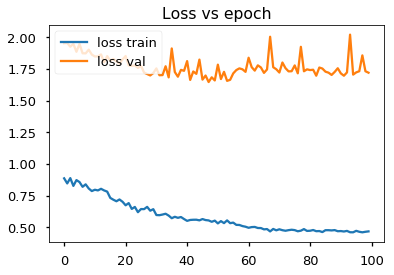

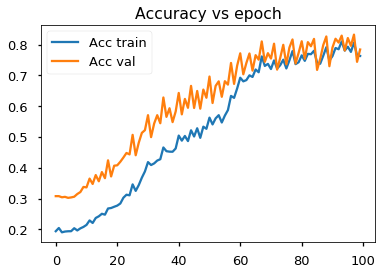

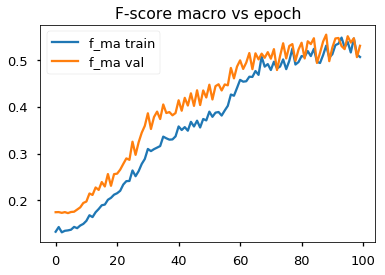

In [23]:
plt.plot(hist_train_loss, label='loss train')
plt.plot(hist_val_loss,label='loss val')
plt.legend(loc='upper left')
plt.title("Loss vs epoch")
plt.show()

plt.plot(hist_train_acc, label='Acc train')
plt.plot(hist_val_acc, label='Acc val')
plt.legend(loc='upper left')
plt.title("Accuracy vs epoch")
plt.show()

plt.plot(hist_train_fma, label='f_ma train')
plt.plot(hist_val_fma, label='f_ma val')
plt.legend(loc='upper left')
plt.title("F-score macro vs epoch")
plt.show()

### Testing model

Testing
SE TUVIERON QUE REPETIR 53 EJEMPLOS
(2176,)
Counter({0: 1298, 1: 368, 3: 310, 2: 200})


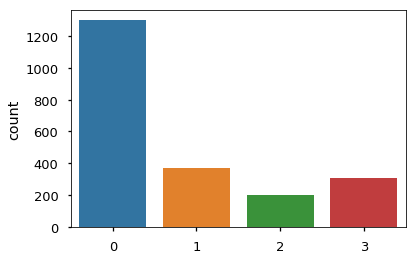

In [24]:
model.eval()
print ("Testing")
predicciones = run_epoch(data_gen(128, 'Test', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
predicciones=np.concatenate(predicciones, axis=-1)
print (predicciones.shape)
print (Counter(predicciones))
sns.countplot(predicciones)

In [25]:
model.eval()
print ("Validando")
loss_val, acc_val,fma_val, f_val_none, cm_val = run_epoch(data_gen(128, 'Val', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
print ("Validando Epoch",epoch)
print ("loss_val:",loss_val)
print ("Acc_val:",acc_val)
print ("f_score_val:",fma_val)
print ("f_score_val:",f_val_none)

Validando
Validando Epoch 99
loss_val: tensor(1.7402)
Acc_val: tensor(0.7845, dtype=torch.float64)
f_score_val: tensor(0.5243, dtype=torch.float64)
f_score_val: tensor([0.8637, 0.2069, 0.1891, 0.8373], dtype=torch.float64)


Counter({0: 3661, 3: 2582, 2: 76, 1: 55})


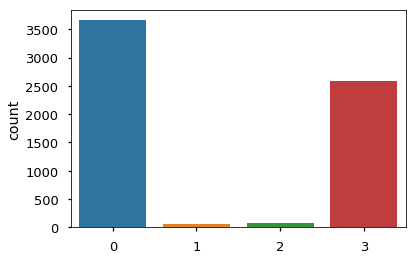

In [26]:
print (Counter(y_train_har))
sns.countplot(y_train_har)

Counter({0: 1493, 3: 525, 1: 71, 2: 36})


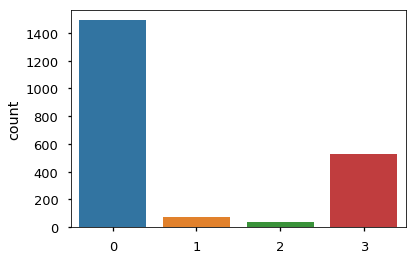

In [27]:
y_val_har=np.load("matrices/y_val_num_4.npy")
print (Counter(y_val_har))
sns.countplot(y_val_har)

#### comparando predicciones del conjunto Validación

En modo testing
(2176,)
Counter({0: 1242, 3: 540, 1: 253, 2: 141})


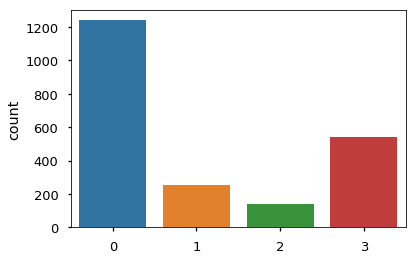

In [28]:
model.eval()
print ("En modo testing")
predicciones_val = run_epoch(data_gen(128, 'Val', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
predicciones_val=np.concatenate(predicciones_val, axis=-1)
print (predicciones_val.shape)
print (Counter(predicciones_val))
sns.countplot(predicciones_val)

# Otros settings